In [26]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week05_explore/q_learning_agent.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week05_explore/replay_buffer.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week05_explore/und1.mp4
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week05_explore/und2.mp4

    !pip install -q gymnasium
    !pip install -q shimmy[bsuite]
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [2]:
from abc import ABCMeta, abstractmethod, abstractproperty
import enum

import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from IPython.display import HTML

HTML("""
    <video alt="test" controls>
        <source src="und1.mp4" type="video/mp4">
    </video>
""")

In [4]:

HTML("""
    <video alt="test" controls>
        <source src="und2.mp4" type="video/mp4">
    </video>
""")

In [5]:
class BernoulliBandit:
    def __init__(self, n_actions=5):
        self._probs = np.random.random(n_actions)

    @property
    def action_count(self):
        return len(self._probs)

    def pull(self, action):
        if np.any(np.random.random() > self._probs[action]):
            return 0.0
        return 1.0

    def optimal_reward(self):
        """ Used for regret calculation
        """
        return np.max(self._probs)

    def action_value(self, action):
        """ Used for regret calculation
        """
        return self._probs[action]

    def step(self):
        """ Used in nonstationary version
        """
        pass

    def reset(self):
        """ Used in nonstationary version
        """

In [6]:
class AbstractAgent(metaclass=ABCMeta):
    def init_actions(self, n_actions):
        self._successes = np.zeros(n_actions)
        self._failures = np.zeros(n_actions)
        self._total_pulls = 0

    @abstractmethod
    def get_action(self):
        """
        Get current best action
        :rtype: int
        """
        pass

    def update(self, action, reward):
        """
        Observe reward from action and update agent's internal parameters
        :type action: int
        :type reward: int
        """
        self._total_pulls += 1
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1

    @property
    def name(self):
        return self.__class__.__name__


class RandomAgent(AbstractAgent):
    def get_action(self):
        return np.random.randint(0, len(self._successes))

### Epsilon-greedy agent

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\hat\theta_k \leftarrow \alpha_k / (\alpha_k + \beta_k)$

&nbsp;&nbsp; **end for**

&nbsp;&nbsp; $x_t \leftarrow argmax_{k}\hat\theta$ with probability $1 - \epsilon$ or random action with probability $\epsilon$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**

Implement the algorithm above in the cell below:

In [7]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon=0.01):
        self._epsilon = epsilon

    def get_action(self):
        if np.random.random() < self._epsilon:
            return np.random.randint(len(self._successes))
        else:
            return np.argmax(self._successes / (self._successes + self._failures + 0.1))

    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon)

### UCB Agent
Epsilon-greedy strategy have no preference for actions. It would be better to select among actions that are uncertain or have potential to be optimal. One can come up with idea of index for each action that represents optimality and uncertainty at the same time. One efficient way to do it is to use UCB1 algorithm:

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w_k \leftarrow \alpha_k / (\alpha_k + \beta_k) + \sqrt{2\log(t) \ / \ (\alpha_k + \beta_k)}$

&nbsp;&nbsp; **end for**

&nbsp;&nbsp; **end for**
 $x_t \leftarrow argmax_{k}w$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**

__Note:__ in practice, one can multiply $\sqrt{2\log(t) \ / \ (\alpha_k + \beta_k)}$ by some tunable parameter to regulate agent's optimism and wilingness to abandon non-promising actions.

More versions and optimality analysis - https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf

In [8]:
class UCBAgent(AbstractAgent):
    def get_action(self):
        pulls = self._successes + self._failures + 0.1
        return np.argmax(self._successes / pulls + np.sqrt(2 * np.log(self._total_pulls + 0.1) / pulls))

### Thompson sampling

UCB1 algorithm does not take into account actual distribution of rewards. If we know the distribution - we can do much better by using Thompson sampling:

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Sample $\hat\theta_k \sim beta(\alpha_k, \beta_k)$

&nbsp;&nbsp; **end for**

&nbsp;&nbsp; $x_t \leftarrow argmax_{k}\hat\theta$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**


More on Thompson Sampling:
https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf

In [9]:
class ThompsonSamplingAgent(AbstractAgent):
    def get_action(self):
        return np.argmax(np.random.beta(self._successes + 1, self._failures + 1))

In [10]:
from collections import OrderedDict

def get_regret(env, agents, n_steps=5000, n_trials=50):
    scores = OrderedDict({
        agent.name: [0.0 for step in range(n_steps)] for agent in agents
    })

    for trial in range(n_trials):
        env.reset()

        for a in agents:
            a.init_actions(env.action_count)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()

            for agent in agents:
                action = agent.get_action()
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - env.action_value(action)

            env.step()  # change bandit's state if it is unstationary

    for agent in agents:
        scores[agent.name] = np.cumsum(scores[agent.name]) / n_trials

    return scores

def plot_regret(agents, scores):
    for agent in agents:
        plt.plot(scores[agent.name])

    plt.legend([agent.name for agent in agents])

    plt.ylabel("regret")
    plt.xlabel("steps")

    plt.show()

<ipython-input-8-13d0e3f28fba>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.argmax(self._successes / pulls + np.sqrt(2 * np.log(self._total_pulls + 0.1) / pulls))


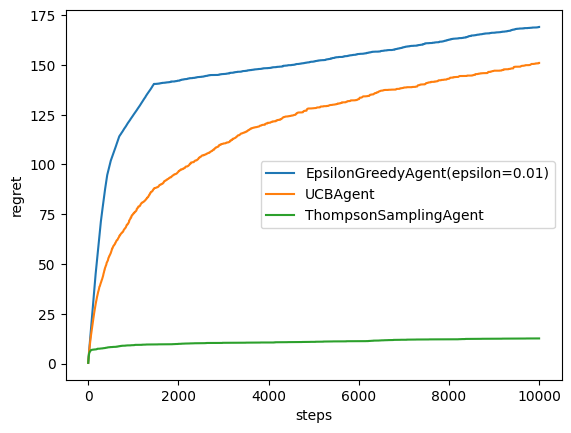

In [11]:
# Uncomment agents
agents = [
    EpsilonGreedyAgent(),
    UCBAgent(),
    ThompsonSamplingAgent()
]

regret = get_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)
plot_regret(agents, regret)

In [12]:
class DriftingBandit(BernoulliBandit):
    def __init__(self, n_actions=5, gamma=0.01):
        """
        Idea from https://github.com/iosband/ts_tutorial
        """
        super().__init__(n_actions)

        self._gamma = gamma

        self._successes = None
        self._failures = None
        self._steps = 0

        self.reset()

    def reset(self):
        self._successes = np.zeros(self.action_count) + 1.0
        self._failures = np.zeros(self.action_count) + 1.0
        self._steps = 0

    def step(self):
        action = np.random.randint(self.action_count)
        reward = self.pull(action)
        self._step(action, reward)

    def _step(self, action, reward):
        self._successes = self._successes * (1 - self._gamma) + self._gamma
        self._failures = self._failures * (1 - self._gamma) + self._gamma
        self._steps += 1

        self._successes[action] += reward
        self._failures[action] += 1.0 - reward

        self._probs = np.random.beta(self._successes, self._failures)

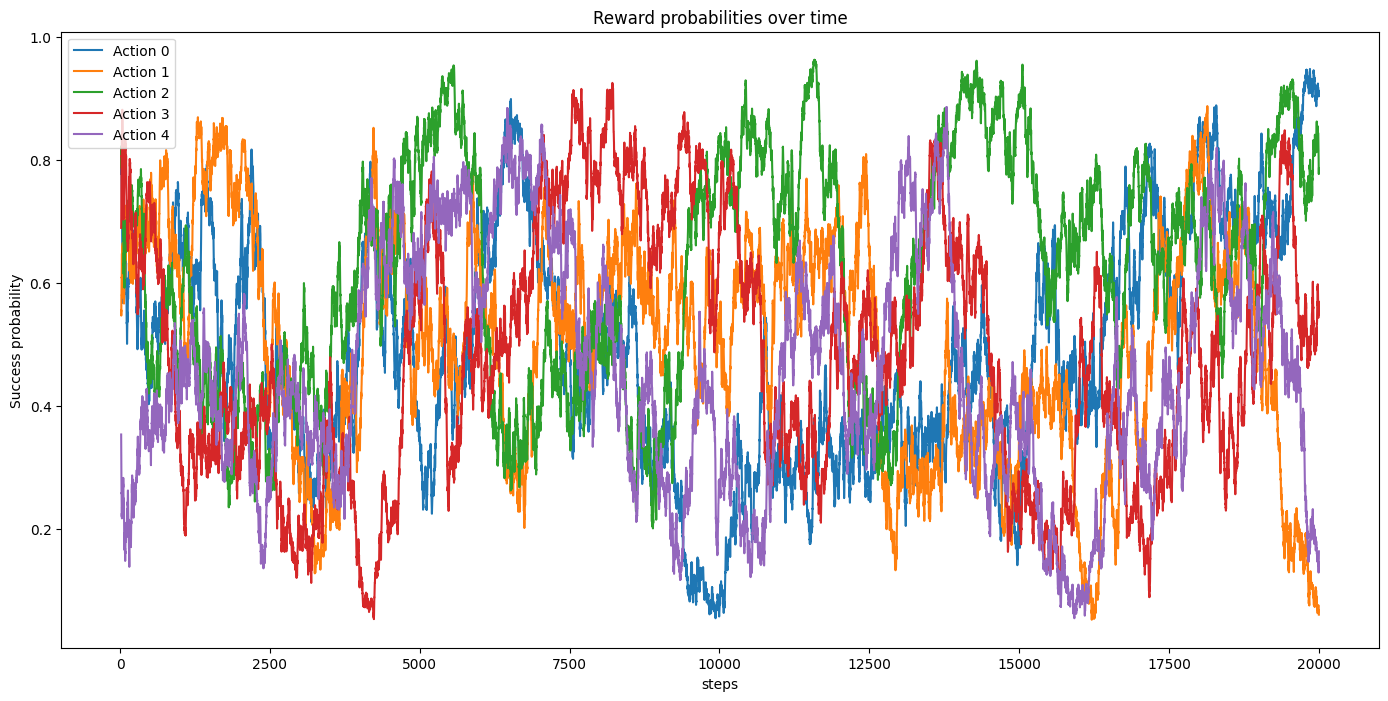

In [13]:
drifting_env = DriftingBandit(n_actions=5)

drifting_probs = []
for i in range(20000):
    drifting_env.step()
    drifting_probs.append(drifting_env._probs)

plt.figure(figsize=(17, 8))
plt.plot(pd.DataFrame(drifting_probs).rolling(window=20).mean())

plt.xlabel("steps")
plt.ylabel("Success probability")
plt.title("Reward probabilities over time")
plt.legend(["Action {}".format(i) for i in range(drifting_env.action_count)])
plt.show()

In [76]:
# YOUR AGENT HERE SECTION
from collections import deque
import numpy as np

class BernoulliBandit(AbstractAgent):
    def __init__(self, W=100):
        self.W = W

    def init_actions(self, n_actions):
        self.S = [0] * n_actions
        self.reward_history = [deque(maxlen=self.W) for _ in range(n_actions)]

    def get_action(self):
        samples = np.random.beta([S + 1 for S in self.S], [len(history) - S + 1 for S, history in zip(self.S, self.reward_history)])
        return np.argmax(samples)

    def update(self, action, reward):
        if len(self.reward_history[action]) == self.W:
            oldest = self.reward_history[action][0]
            self.S[action] -= oldest
        self.reward_history[action].append(reward)
        self.S[action] += reward

<ipython-input-8-13d0e3f28fba>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.argmax(self._successes / pulls + np.sqrt(2 * np.log(self._total_pulls + 0.1) / pulls))


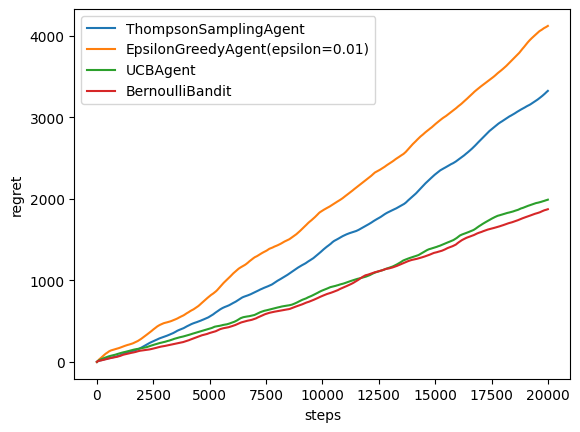

In [77]:
drifting_agents = [
    ThompsonSamplingAgent(),
    EpsilonGreedyAgent(),
    UCBAgent(),
    BernoulliBandit()
]

regret = get_regret(DriftingBandit(), drifting_agents, n_steps=20000, n_trials=10)
plot_regret(drifting_agents, regret)

In [78]:
import shimmy

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from time import sleep
from tqdm import tqdm
from IPython.display import clear_output

from q_learning_agent import QLearningAgent
from replay_buffer import ReplayBuffer

env = gym.make("bsuite/deep_sea-v0", size=10, seed=42)

2.1 Epsilon-greedy q-learning

In [79]:
def get_state_number(s):
    return np.argmax(s.flatten())

def test_agent(agent, greedy=True, delay=.5):
    v = get_all_states_value(agent)
    s, _ = env.reset()
    done = False
    while not done:
        fig, ax = plt.subplots(ncols=2)
        ax[0].imshow(s)
        ax[0].set_title('State')
        im = ax[1].imshow(v)
        plt.colorbar(im)
        ax[1].set_title('Value function')
        clear_output(True)
        plt.show()
        s = get_state_number(s)
        if greedy:
            a = agent.get_best_action(s)
        else:
            a = agent.get_action(s)

        s, r, terminated, truncated, _  = env.step(a)
        done = terminated or truncated
        sleep(delay)

def get_all_states_value(agent):
    s_shape = env.observation_space.shape
    s_shape_flatten = np.prod(s_shape)
    v = np.zeros(s_shape_flatten)
    for i in range(s_shape_flatten):
        v[i] = agent.get_value(i)
    v = v.reshape(s_shape)
    return v

def to_one_hot(x, ndims):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    x = x.long().view(-1, 1)
    x = torch.zeros(
        x.size()[0], ndims).scatter_(1, x, 1)
    return x

In [80]:
agent = QLearningAgent(
    epsilon=1,
    alpha=0.5,
    discount=1,
    get_legal_actions=lambda s: range(env.action_space.n)
)

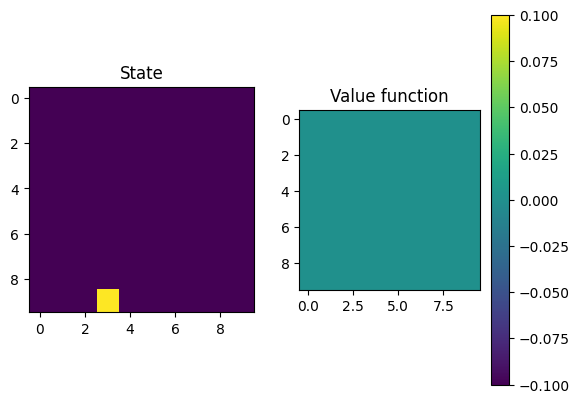

In [39]:
test_agent(agent, greedy=True)

In [40]:
for i in range(5000):
    s, _ = env.reset()
    done = False
    while not done:
        i_s = get_state_number(s)
        a = agent.get_action(i_s)
        s_next, r, terminated, truncated, _  = env.step(a)
        done = terminated or truncated
        i_s_next = get_state_number(s_next)
        agent.update(i_s, a, r, i_s_next, terminated)
        s = s_next

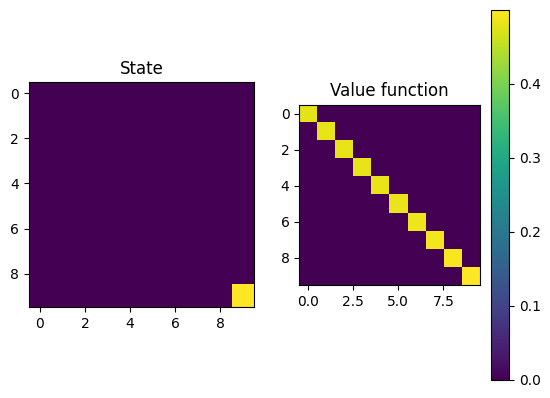

In [41]:
test_agent(agent)

In [42]:
env = gym.make("bsuite/deep_sea-v0", size=12, seed=42)

In [43]:
agent = QLearningAgent(
    epsilon=1,
    alpha=0.5,
    discount=1,
    get_legal_actions=lambda s: range(env.action_space.n)
)

for i in range(5000):
    s, _ = env.reset()
    done = False
    while not done:
        i_s = get_state_number(s)
        a = agent.get_action(i_s)
        s_next, r, terminated, truncated, _  = env.step(a)
        done = terminated or truncated
        i_s_next = get_state_number(s_next)
        agent.update(i_s, a, r, i_s_next, terminated)
        s = s_next

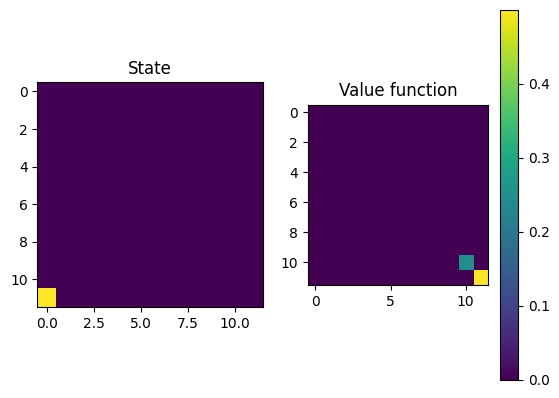

In [44]:
test_agent(agent)

In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class BaseIntrinsicRewardModule(nn.Module):
    def __init__(self):
        super().__init__()

    def get_intrinsic_reward(self, state, action, next_state):
        return 0.0

    def get_loss(self, state_batch, action_batch, next_state_batch):
        pass

In [111]:
def train_with_reward(env, agent, reward_module, n_episodes=100, update_reward_period=100, batch_size=100, n_iter=10):
    buffer = ReplayBuffer(size=int(1e6))

    if list(reward_module.parameters()):
        optimizer = torch.optim.Adam(reward_module.parameters())
    else:
        optimizer = None

    losses = []
    s, _ = env.reset()

    for i in range(n_episodes):
        done = False

        while not done:
            i_s = get_state_number(s)
            a = agent.get_action(i_s)
            s_next, r, terminated, truncated, _  = env.step(a)
            done = terminated or truncated
            i_s_next = get_state_number(s_next)

            state_t = torch.tensor(s).float().view(1, -1)
            action_t = torch.tensor(a).float().view(1, -1)
            next_state_t = torch.tensor(s_next).float().view(1, -1)

            r_intr = reward_module.get_intrinsic_reward(state_t, action_t, next_state_t)
            r += r_intr

            agent.update(i_s, a, r, i_s_next, terminated)
            buffer.add(np.array(s), np.array(a), np.array(r), np.array(s_next), np.array(terminated))

            s = s_next

        if (i + 1) % update_reward_period == 0 and optimizer is not None:

            for _ in range(n_iter):
                optimizer.zero_grad()
                state_batch, action_batch, _, next_state_batch, _ = buffer.sample(batch_size)

                state_tensor = torch.tensor(state_batch).float().flatten(1, 2)
                action_tensor = torch.tensor(action_batch).float().view(-1, 1)
                next_state_tensor = torch.tensor(next_state_batch).float().flatten(1, 2)

                loss = reward_module.get_loss(state_tensor, action_tensor, next_state_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

            fig, ax = plt.subplots(ncols=2)
            ax[0].set_title('Value function after iter: %d' % i)
            im = ax[0].imshow(get_all_states_value(agent))
            ax[1].plot(losses)
            ax[1].set_title('Random network distillation loss')
            clear_output(True)
            plt.show()

In [112]:
class GoRightReward(BaseIntrinsicRewardModule):
    def __init__(self):
        super().__init__()

    def get_intrinsic_reward(self, state, action, next_state):
        return 0.01 if action.item() == 1 else 0.0

In [113]:
agent = QLearningAgent(
    epsilon=.1,
    alpha=0.5,
    discount=.9,
    get_legal_actions=lambda s: range(env.action_space.n)
)

go_right = GoRightReward()

train_with_reward(env, agent, go_right, n_episodes=500)

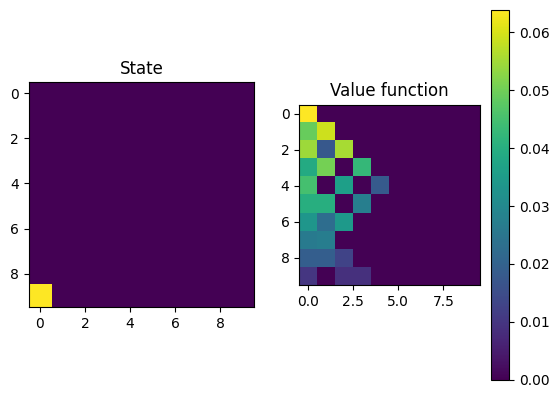

In [114]:
test_agent(agent, greedy=True)

2.3 Curiosity-driven Exploration

In [115]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

        def init_weights(tensor):
            if isinstance(tensor, nn.Linear):
                nn.init.xavier_uniform_(tensor.weight)

        self.layers.apply(init_weights)


    def forward(self, x):
        return self.layers(x)

2.3.1 Uncertainty with forward dynamics

In [116]:
class ForwardDynamics(BaseIntrinsicRewardModule):
    def __init__(self, states_size, actions_size, hidden_size, alpha=.1):
        super().__init__()
        self.module = MLP(
            actions_size + states_size,
            hidden_size,
            states_size
        )
        self.alpha = alpha
        self.mean_reward = 0

    def forward(self, s, a):
        sa = torch.cat([s, a], dim=-1)
        return s + self.module(sa)

    def get_intrinsic_reward(self, state, action, next_state):
        with torch.no_grad():
            predicted = self.forward(state, action)
            error = ((predicted - next_state) ** 2).mean()
            r = error
            r_centered = r - self.mean_reward
            self.mean_reward = self.alpha * r + (1 - self.alpha) * self.mean_reward
            return r_centered

    def get_loss(self, state_batch, action_batch, next_state_batch):
        predicted = self.forward(state_batch, action_batch)
        loss = ((predicted - next_state_batch) ** 2).mean()
        return loss

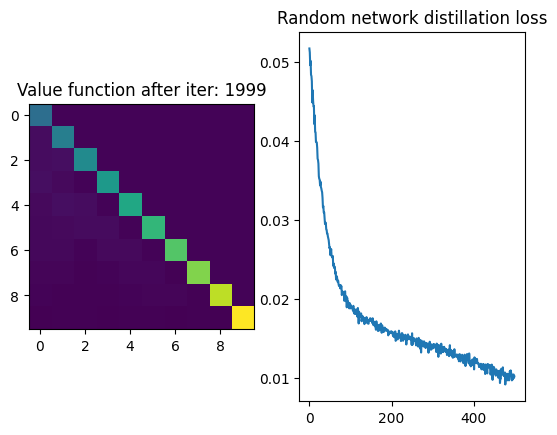

In [117]:
agent = QLearningAgent(
    epsilon=.1,
    alpha=0.5,
    discount=.9,
    get_legal_actions=lambda s: range(env.action_space.n)
)

forward_dynamics = ForwardDynamics(
    np.prod(env.observation_space.shape),
    1,
    16
)

train_with_reward(env, agent, forward_dynamics, n_episodes=2000, update_reward_period=100, batch_size=100, n_iter=25)

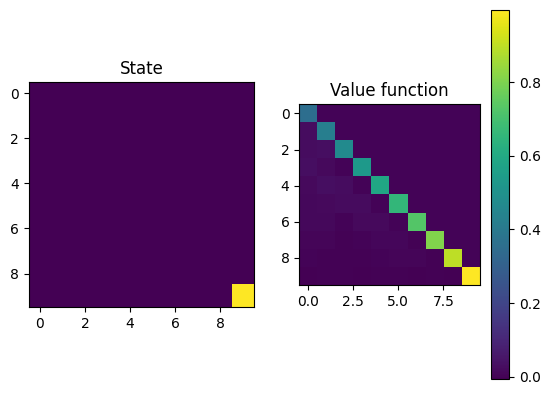

In [118]:
test_agent(agent)


2.3.2 Uncertainty with reverse dynamics

In [128]:
import torch
import torch.nn.functional as F

class InverseDynamics(BaseIntrinsicRewardModule):
    def __init__(self, states_size, n_actions, hidden_size, alpha=0.1):
        super().__init__()
        self.module = MLP(
            2 * states_size,
            hidden_size,
            n_actions
        )
        self.alpha = alpha
        self.mean_reward = 0
        self.n_actions = n_actions

    def forward(self, s, s_next):
        ss_next = torch.cat([s, s_next], dim=-1)
        return self.module(ss_next)

    def get_intrinsic_reward(self, state, action, next_state):
        with torch.no_grad():
            logits = self.forward(state, next_state)
            log_probs = F.log_softmax(logits, dim=-1)
            r = -log_probs[0, int(action.item())]
            r_centered = r - self.mean_reward
            self.mean_reward = self.alpha * r + (1 - self.alpha) * self.mean_reward
            return r_centered

    def get_loss(self, state_batch, action_batch, next_state_batch):
        logits = self.forward(state_batch, next_state_batch)
        actions = action_batch.long().view(-1)
        return F.cross_entropy(logits, actions)

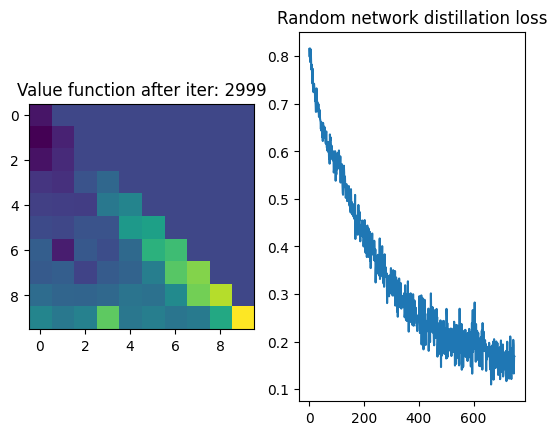

In [129]:
agent = QLearningAgent(
    epsilon=.1,
    alpha=0.5,
    discount=.9,
    get_legal_actions=lambda s: range(env.action_space.n)
)

inverse_dynamics = InverseDynamics(
    np.prod(env.observation_space.shape),
    env.action_space.n,
    16
)

train_with_reward(env, agent, inverse_dynamics, n_episodes=3000,
                  update_reward_period=100, batch_size=100, n_iter=25)

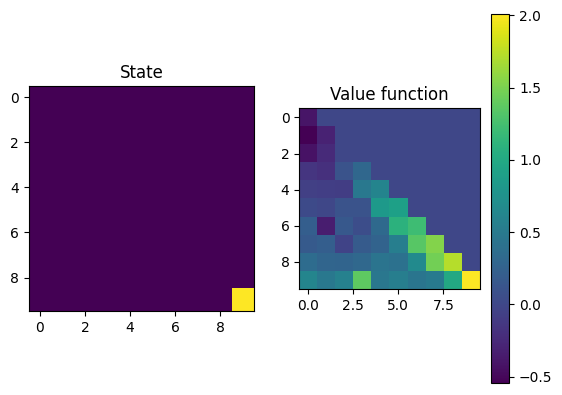

In [130]:
test_agent(agent)

2.3.3 Intrinsic Curiosity Module algorithm

In [122]:
class Embedder(nn.Module):
    def __init__(self, states_size, embedding_size, hidden_size):
        super().__init__()
        self.module = MLP(
            states_size,
            hidden_size,
            embedding_size
        )

    def forward(self, s):
        return self.module(s)

class ICMModule(BaseIntrinsicRewardModule):
    def __init__(self, states_size, n_actions, hidden_size, embedding_size):
        super().__init__()
        self.n_actions = n_actions
        self.state_encoder = MLP(states_size, hidden_size, embedding_size)
        self.forward_dynamics = MLP(embedding_size + n_actions, hidden_size, embedding_size)
        self.inverse_dynamics = MLP(embedding_size * 2, hidden_size, n_actions)
        self.mean_reward = 0
        self.alpha = 0.1

    def get_intrinsic_reward(self, state, action, next_state):
        with torch.no_grad():
            state_emb = self.state_encoder(state)
            next_state_emb = self.state_encoder(next_state)
            action_onehot = F.one_hot(action.long().squeeze(), num_classes=self.n_actions).float()
            sa_emb = torch.cat([state_emb, action_onehot.view(1, -1)], dim=-1)
            predicted_next_emb = self.forward_dynamics(sa_emb)
            forward_error = ((predicted_next_emb - next_state_emb) ** 2).mean()
            ss_next_emb = torch.cat([state_emb, next_state_emb], dim=-1)
            logits = self.inverse_dynamics(ss_next_emb)
            log_probs = F.log_softmax(logits, dim=-1)
            inverse_error = -log_probs[0, int(action.item())]
            r = 0.8 * forward_error + 0.2 * inverse_error
            r_centered = r - self.mean_reward
            self.mean_reward = self.alpha * r + (1 - self.alpha) * self.mean_reward
            return r_centered

    def get_loss(self, state_batch, action_batch, next_state_batch):
        state_emb = self.state_encoder(state_batch)
        next_state_emb = self.state_encoder(next_state_batch)
        action_onehot = F.one_hot(action_batch.long().squeeze(1), num_classes=self.n_actions).float()
        sa_emb = torch.cat([state_emb, action_onehot], dim=-1)
        predicted_next_emb = self.forward_dynamics(sa_emb)
        forward_loss = ((predicted_next_emb - next_state_emb) ** 2).mean()
        ss_next_emb = torch.cat([state_emb, next_state_emb], dim=-1)
        logits = self.inverse_dynamics(ss_next_emb)
        inverse_loss = F.cross_entropy(logits, action_batch.long().squeeze(1), reduction='mean')
        total_loss = 0.8 * forward_loss + 0.2 * inverse_loss
        return total_loss

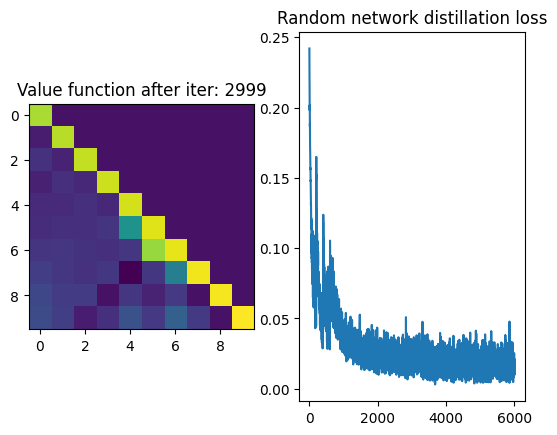

In [123]:
agent = QLearningAgent(
    epsilon=.1,
    alpha=0.5,
    discount=1,
    get_legal_actions=lambda s: range(env.action_space.n)
)

icm = ICMModule(
    states_size=np.prod(env.observation_space.shape),
    n_actions=env.action_space.n,
    hidden_size=16, embedding_size=10
)

train_with_reward(env, agent, icm, n_episodes=3000, update_reward_period=100, batch_size=100, n_iter=200)

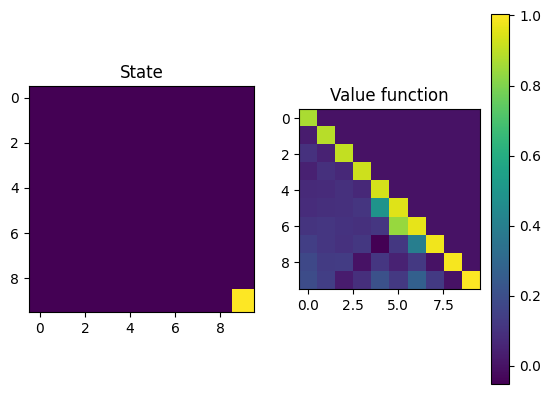

In [124]:
test_agent(agent)

HW 2.1: Random network distillation

Implement algorithm from https://arxiv.org/abs/1810.12894 paper

In [125]:
class RandomNetworkDistilationModule(BaseIntrinsicRewardModule):
    def __init__(self, states_size, hidden_size, output_size=128):
        super().__init__()
        self.target = MLP(states_size, hidden_size, output_size)
        for param in self.target.parameters():
            param.requires_grad = False
        self.predictor = MLP(states_size, hidden_size, output_size)

    def get_intrinsic_reward(self, state, action, next_state):
        with torch.no_grad():
            target_output = self.target(next_state)
            predicted_output = self.predictor(next_state)
            r = ((predicted_output - target_output)**2).sum().item()
            return r

    def get_loss(self, state_batch, action_batch, next_state_batch):
        predicted_output_batch = self.predictor(state_batch)
        target_output_batch = self.target(state_batch).detach()
        loss = ((predicted_output_batch - target_output_batch)**2).mean()
        return loss

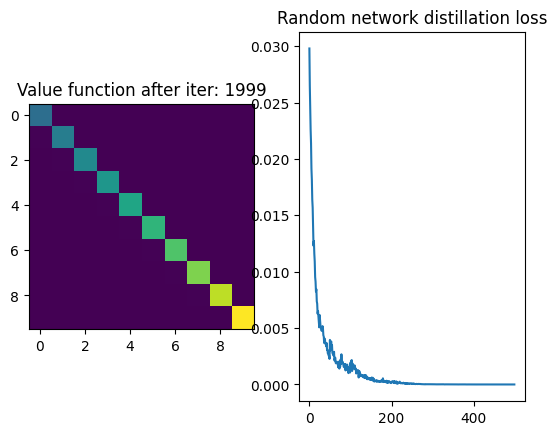

In [126]:
agent = QLearningAgent(
    epsilon=.1,
    alpha=0.5,
    discount=.9,
    get_legal_actions=lambda s: range(env.action_space.n)
)

rnd = RandomNetworkDistilationModule(
    np.prod(env.observation_space.shape),
    np.prod(env.observation_space.shape),
    16
)

train_with_reward(env, agent, rnd, n_episodes=2000, update_reward_period=100, batch_size=100, n_iter=25)

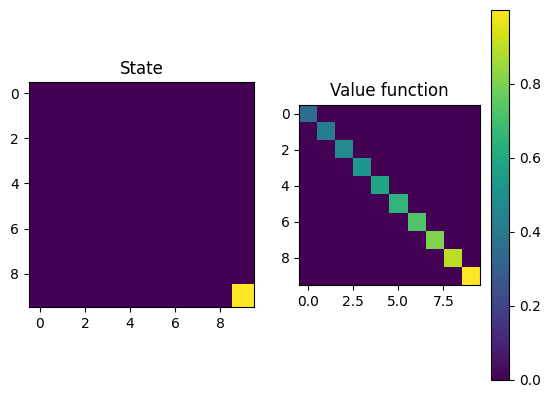

In [127]:
test_agent(agent)